In [1]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import ops
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train = np.load("numeros_data.npy") # Números
X_train=X_train/255
X_train = np.expand_dims(X_train, axis=-1).astype(np.float32)
print(f"Imagenes de entrenamiento: {X_train.shape}")

Imagenes de entrenamiento: (60000, 28, 28, 1)


In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │         6,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,602,305 (6.11 MB)

 Trainable params: 1,602,305 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrear puntos aleatorios
        batch_size = keras.ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Imágenes falsas
        generated_images = self.generator(random_latent_vectors)

        # Combinar con imágenes reales
        combined_images = keras.ops.concatenate([generated_images, real_images], axis=0)

        # Concatenar imágenes
        labels = keras.ops.concatenate(
            [keras.ops.ones((batch_size, 1)), keras.ops.zeros((batch_size, 1))], axis=0
        )
        # Agregar ruido
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenar el discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Muestrear imágenes
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Unir imágenes
        misleading_labels = keras.ops.zeros((batch_size, 1))

        # Entrenar el generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Actualizar funcion de perdida
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [6]:
# Define los optimizadores y la función de pérdida
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Instancia y compila el modelo GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer, loss_fn=loss_fn)

# Entrenamiento del modelo
batch_size = 128
epochs = 20 

# Prepara los datos en formato tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1024).batch(batch_size)

# Inicia el entrenamiento
gan.fit(dataset, epochs=epochs)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 378ms/step - d_loss: 0.5892 - g_loss: 0.8657
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - d_loss: 0.6534 - g_loss: 0.8424
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - d_loss: 0.6494 - g_loss: 0.8434
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 386ms/step - d_loss: 0.6645 - g_loss: 0.8064
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 385ms/step - d_loss: 0.6612 - g_loss: 0.8055
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 385ms/step - d_loss: 0.6618 - g_loss: 0.8114
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 394ms/step - d_loss: 0.6609 - g_loss: 0.8143
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 386ms/step - d_loss: 0.6595 - g_loss: 0.8116
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - d_loss: 0.6618 - g_loss: 0.8170
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 383ms/step - d_loss: 0.6611 - g_loss: 0.8155
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 382ms/step - d_loss: 0.6610 - g_loss: 0.8195
Epoch 12

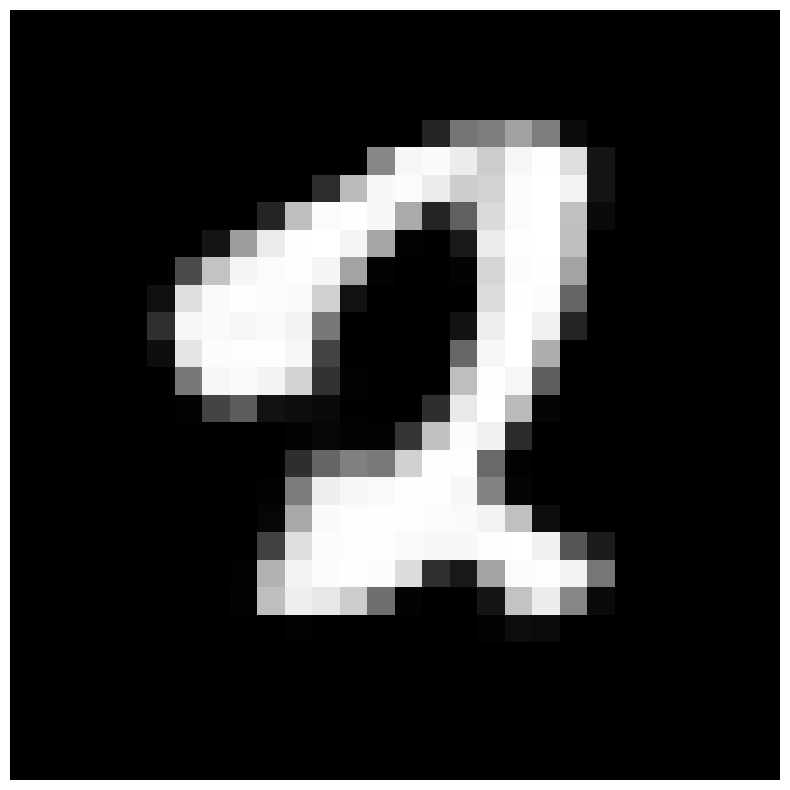

In [44]:
def generate_images(generator, latent_dim, num_images=1):
    # Generar vectores de ruido aleatorio
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

    # Generar imágenes con el generador
    generated_images = generator(random_latent_vectors)

    # Escalar las imágenes para visualización (0-1)
    generated_images = (generated_images * 255).numpy().astype("uint8")

    # Mostrar las imágenes generadas
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

# Ejemplo de uso
generate_images(generator, latent_dim=128, num_images=1)
